### Multi-class Text Classification using Word Embeddings

The code is adjusted from: https://github.com/emmanuellaanggi/disaster_tweet_sentiment/blob/master/(Medium)_Text_Classification_Disaster_Tweet_.ipynb
Please also be reminded to cite their code when using it.

The code is developed using Word Embedding and Bidirectional Long Short-Term Memory techniques. 

In [ ]:
# To download the word embeddings, please refer to the link

import requests, zipfile, io

# to refer to FastText
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

# to refer to GloVe
# zip_file_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"

r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

%matplotlib inline

In [2]:
# clean tweet data

import re
import nltk
import emoji
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
# prefer to create own stopword list

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_punctuations(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def remove_digits(text):
    text = ''.join([digit for digit in text if not digit.isdigit()])
    return text

def remove_emojis(text):
    text = re.sub(emoji.get_emoji_regexp(), r"", text)
    return text

def remove_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

def nltk2wn_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None
    
def lemmatize_text(text):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
    wn_tagged = map(lambda x: (x[0], nltk2wn_tag(x[1])), nltk_tagged)
    res_words = []
    for word, tag in wn_tagged:
        if tag is None:            
            res_words.append(word)
        else:
            res_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(res_words)

def clean_text(text):
    text = text.replace("&#39;", "'")
    text = text.replace("&quot;", "")
    text = text.replace("&amp;", "")
    text = text.replace("‘", "'")
    text = text.replace("’", "'")
    text = text.replace("“", "'")
    text = text.replace("”", "'")
    text = text.replace(" – ", " ")
    text = text.replace("—", " ")
    text = text.replace("•", " ")
    text = re.sub(r'http\S+', '', text)
    text = re.sub('(RT\s@[A-Za-z0-9-_]+[A-Za-z0-9-_]: +)', '', text)
    text = re.sub('(@[A-Za-z0-9-_]+[A-Za-z0-9-_]+)', '', text)
    text = text.lower()
    text = remove_punctuations(text)
    text = remove_digits(text)
    text = remove_emojis(text)
    #text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

[nltk_data] Downloading package punkt to /Users/lingyaoli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lingyaoli/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lingyaoli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lingyaoli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
# read original training and testing data files

train_df = pd.read_excel('training_2.xlsx')
test_df = pd.read_excel('testing_2.xlsx')

train_df['clean_text'] = train_df['text'].apply(clean_text)
test_df['clean_text'] = test_df['text'].apply(clean_text)

print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

Number of training data  2498
Number of testing data:  800


In [ ]:
# read augmented training data files

dff1 = pd.read_csv('earthquake_1_aug.txt', sep='\t', names=["label","clean_text"])
dff1 = dff1.sample(frac=1)
dff2 = pd.read_csv('earthquake_2_aug.txt', sep='\t', names=["label","clean_text"])
dff2 = dff2.sample(frac=1)
dff3 = pd.read_csv('earthquake_3_aug.txt', sep='\t', names=["label","clean_text"])
dff3 = dff3.sample(frac=1)
dff0 = pd.read_csv('earthquake_0_aug.txt', sep='\t', names=["label","clean_text"])
dff0 = dff0.sample(frac=1)

train_df = pd.concat([dff1, dff2, dff3, dff0])

test_df = pd.read_excel('testing_2.xlsx')
test_df['clean_text'] = test_df['text'].apply(clean_text)

print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

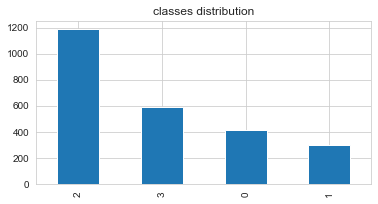

In [4]:
labels = ['3', '2', '1', '0']
plt.figure(figsize=(6,3))
plt.title('classes distribution')
train_df['label'].value_counts().plot(kind='bar')

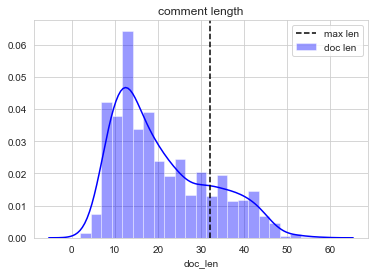

In [5]:
# view the length of tweets in the training dataset

label_names = ["label"]
y_train = train_df[label_names].values

train_df['doc_len'] = train_df['clean_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length')
plt.legend()
plt.show()

In [6]:
# import word embeddings

import codecs
from tqdm import tqdm

embeddings_index = {}

# apply FastText word embedding
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')

# apply GloVe word embedding
# f = codecs.open('glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

1999996it [03:09, 10558.02it/s]

found 1999996 word vectors


In [7]:
import keras
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

tokenizer = RegexpTokenizer(r'\w+')

# adjust the max number of words given the tweet data

MAX_NB_WORDS = 1000

raw_docs_train = train_df['clean_text'].tolist()
raw_docs_test = test_df['clean_text'].tolist() 
num_classes = len(label_names)

print("----- pre-processing train data -----")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    processed_docs_train.append(" ".join(tokens))

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    processed_docs_test.append(" ".join(tokens))
    
print("----- tokenizing input data -----")

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

# pad sequences to guarantee all the vectors have the same length

word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

----- pre-processing train data -----


100%|██████████| 800/800 [00:00<00:00, 6865.67it/s]


----- tokenizing input data -----
dictionary size:  4606


In [8]:
# prepare embedding matrix

embed_dim = 300 # this number depends on the word embedding vectors

print('----- preparing embedding matrix -----')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

----- preparing embedding matrix -----


In [9]:
# compile deep learning model with keras

import tensorflow as tf

from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

# adjust the hyperparameters

batch_size = 32
num_epochs = 30
learning_rate = 0.01
drop_rate = 0.4

# apply Keras to compile the deep learning model
# binary classification: sigmoid, binary_crossentropy
# multi-class classification: softmax, categorical_crossentropy

model = tf.keras.Sequential()

model.add(Embedding(nb_words, embed_dim, input_length=max_seq_len, weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(drop_rate))
model.add(Dense(4,activation='softmax'))
adam = optimizers.Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 300)           300000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 387,460
Trainable params: 87,460
Non-trainable params: 300,000
_________________________________________________________________


In [10]:
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)
# to apply if it needs early stopping
# es_callbacks = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
history = model.fit(word_seq_train, y_train_cat, batch_size, epochs=num_epochs, 
                    validation_split=0.2, shuffle=False)

Train on 1998 samples, validate on 500 samples
Epoch 1/30
1998/1998 [==============================] - 5s 2ms/step - loss: 1.1678 - acc: 0.5506 - val_loss: 1.7690 - val_acc: 0.1700
Epoch 2/30
1998/1998 [==============================] - 3s 1ms/step - loss: 0.9501 - acc: 0.6496 - val_loss: 1.5112 - val_acc: 0.1720
Epoch 3/30
1998/1998 [==============================] - 3s 1ms/step - loss: 0.7903 - acc: 0.7077 - val_loss: 1.1461 - val_acc: 0.3440
Epoch 4/30
1998/1998 [==============================] - 3s 1ms/step - loss: 0.7083 - acc: 0.7362 - val_loss: 0.8702 - val_acc: 0.7460
Epoch 5/30
1998/1998 [==============================] - 3s 1ms/step - loss: 0.6189 - acc: 0.7613 - val_loss: 0.6755 - val_acc: 0.8360
Epoch 6/30
1998/1998 [==============================] - 3s 2ms/step - loss: 0.5611 - acc: 0.7958 - val_loss: 0.6156 - val_acc: 0.8220
Epoch 7/30
1998/1998 [==============================] - 3s 2ms/step - loss: 0.4758 - acc: 0.8293 - val_loss: 0.5746 - val_acc: 0.8300
Epoch 8/30
1998

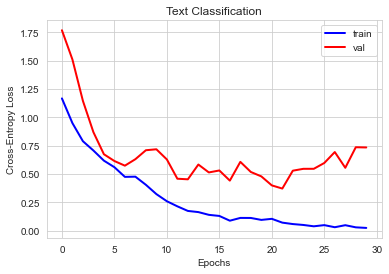

In [11]:
# generate loss plots

plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Text Classification')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

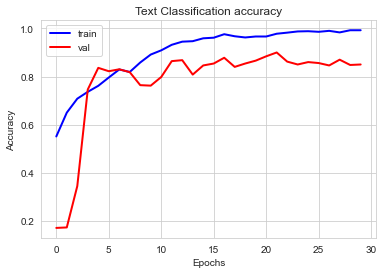

In [12]:
# generate accuracy plots

plt.figure()
plt.plot(history.history['acc'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('Text Classification accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [13]:
# output classification performance

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

labels = ['3', '2', '1', '0']

predictions = model.predict_classes(word_seq_test)
sample = pd.read_excel('testing_2.xlsx')
sample['pred'] = pd.Series(predictions)
sample[['pred', "label"]]

print("Testing accuracy with FastText: %.2f%%" % (accuracy_score(sample.label, sample.pred)*100))
print(classification_report(sample.label, sample.pred, target_names=labels))

Tesing accuracy with FastText: 83.00%
              precision    recall  f1-score   support

           3       0.87      0.75      0.80       197
           2       0.59      0.74      0.66       136
           1       0.93      0.90      0.92       448
           0       0.48      0.58      0.52        19

    accuracy                           0.83       800
   macro avg       0.72      0.74      0.73       800
weighted avg       0.84      0.83      0.83       800

